# GOAL
Predict tomorrow's temperature, given the temprature until today, as precisely as possible.

# Load Packages

In [298]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# machine learning stack
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.arima_process import ArmaProcess
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller, kpss



# time-related stack
from dateutil.relativedelta import relativedelta
from datetime import datetime as dt

# miscellaneous
import time
import warnings
warnings.filterwarnings("ignore")

# Data 
Data was preprossed in "time_series_data_processing.ipynb"

# Visualizaiton

First I look at different time intervalls. 

In [214]:
df = pd.read_csv('data/clean_df.csv')
df.head()

,date,temp
0,1876-01-01,2.2
1,1876-01-02,2.5
2,1876-01-03,0.3
3,1876-01-04,-5.8
4,1876-01-05,-9.8


<AxesSubplot: >

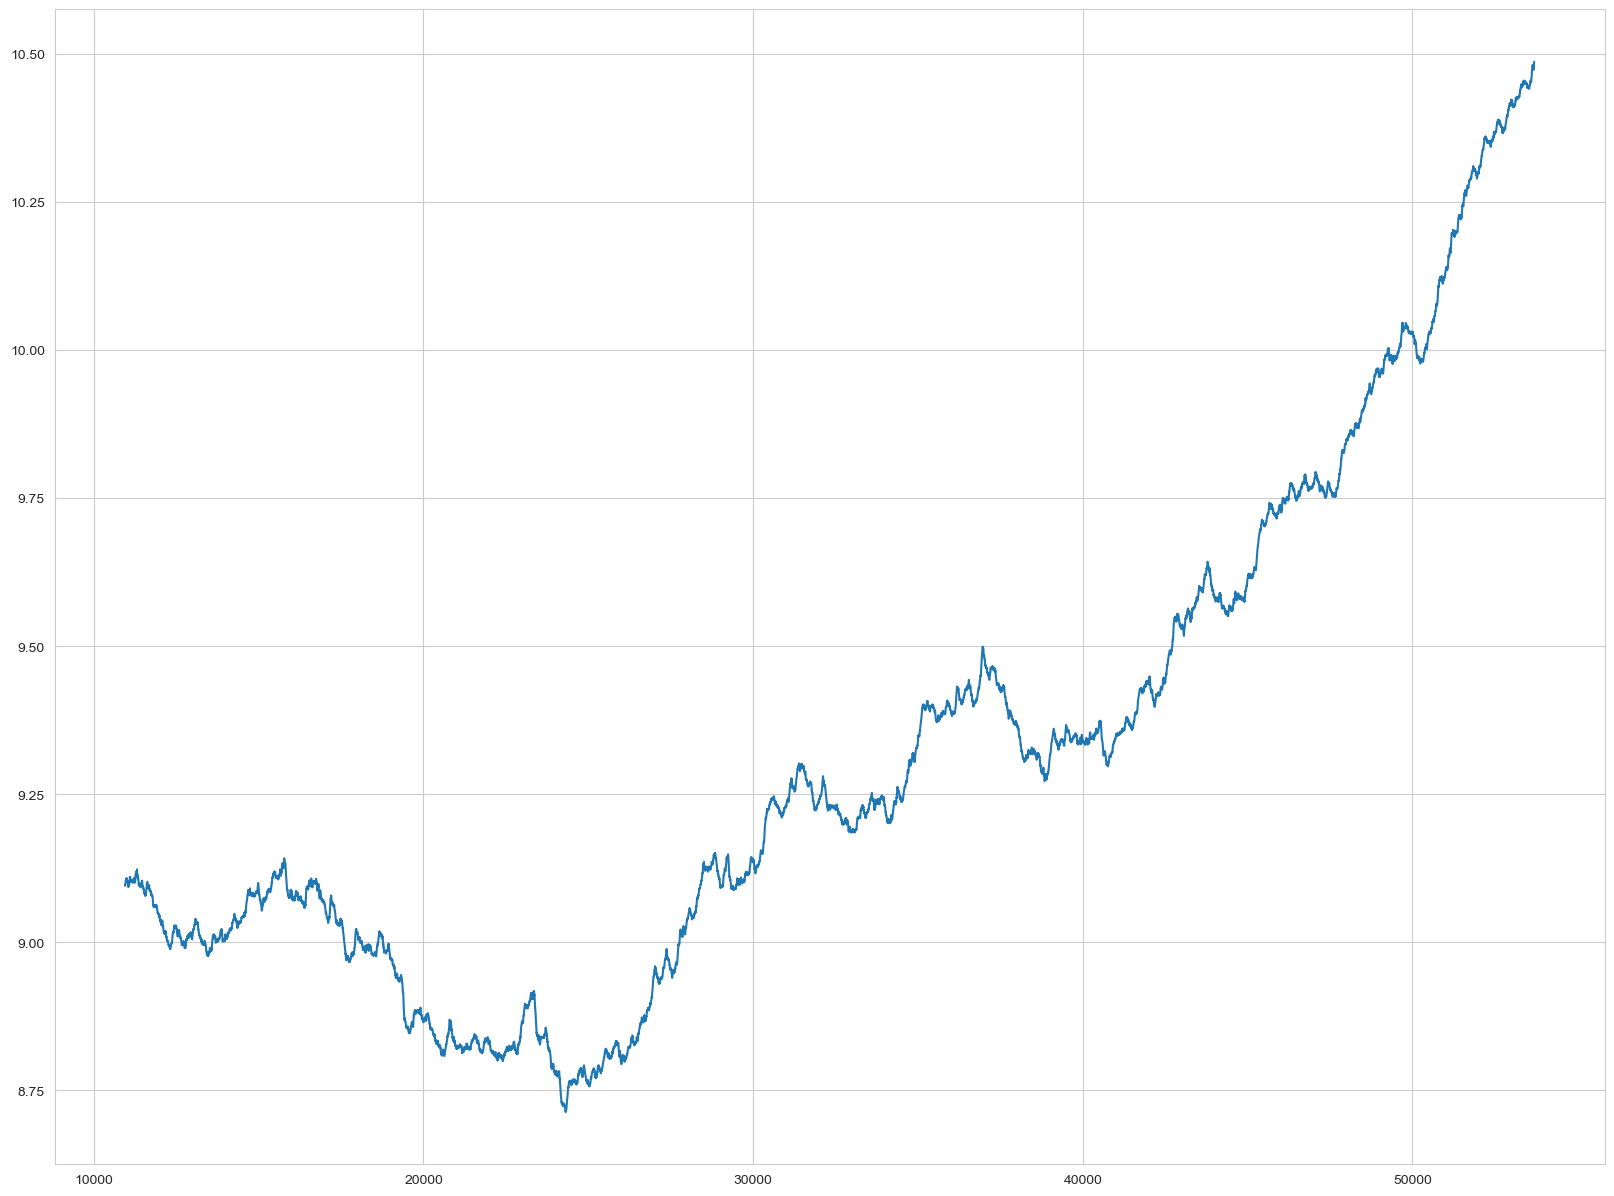

In [215]:
# to get an overview with rolling window of 30 years (365 days is maybe not the best)
years_30 = 30 *365
df_30_years = df.temp.rolling(window = years_30).mean()
df_30_years.plot(figsize = (20,15))

<AxesSubplot: >

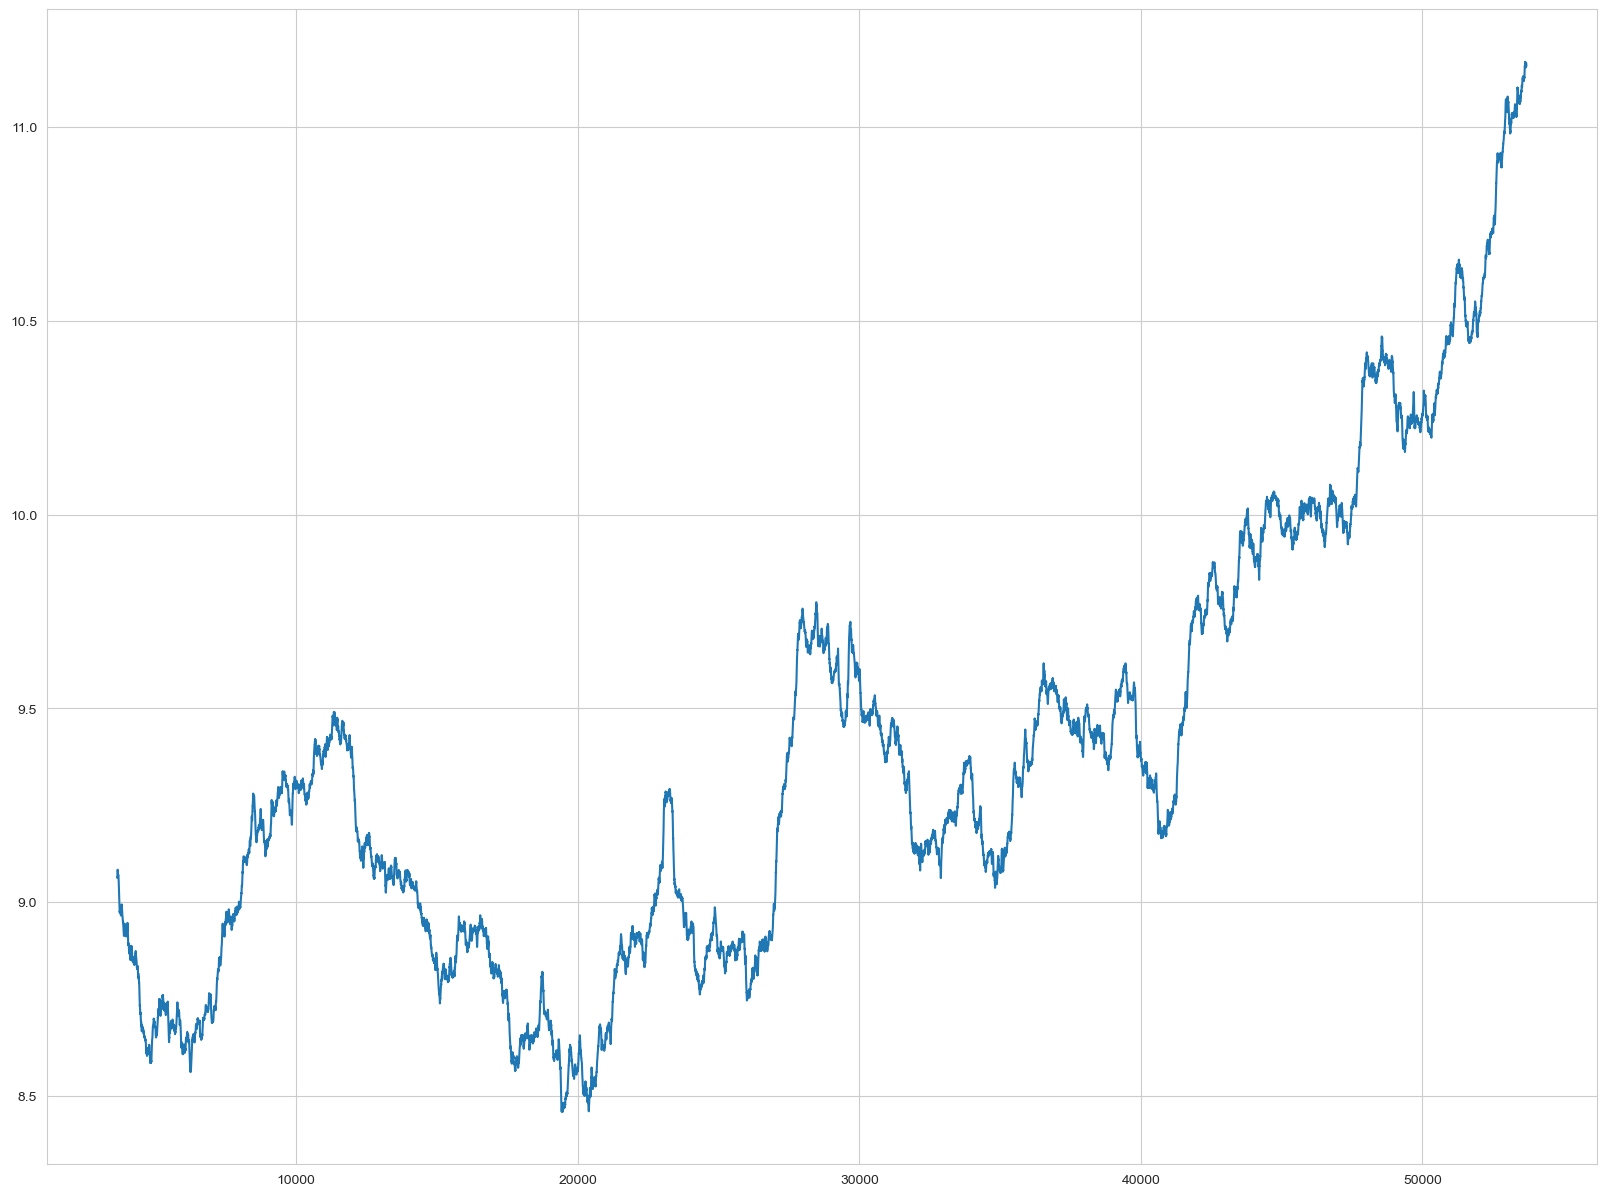

In [216]:
years_10 = 10 *365
df_10_years = df.temp.rolling(window = years_10).mean()
df_10_years.plot(figsize = (20,15))

# Model / Feature Engineering

## Model Trend

In [217]:
train = pd.read_csv('data/train.csv',index_col=0,parse_dates=True)

In [218]:
train.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [219]:
# engineer timestep variable for future convenience
train['timestep'] = list(range(train.shape[0]))

In [220]:
X_trend = train[['timestep']]
y_trend = train['temp']

In [221]:
# trend model

trend_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

In [222]:
# fit model

trend_model.fit(X_trend,y_trend)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [223]:
train['trend'] = trend_model.predict(X_trend)

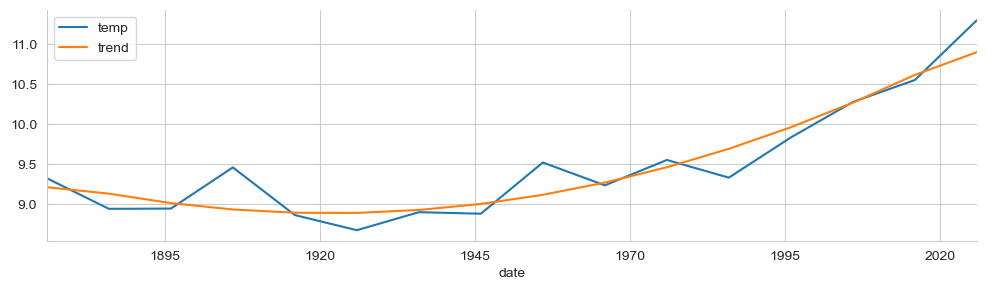

In [224]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['temp','trend']].resample('10Y').mean().plot(legend=True)
sns.despine()

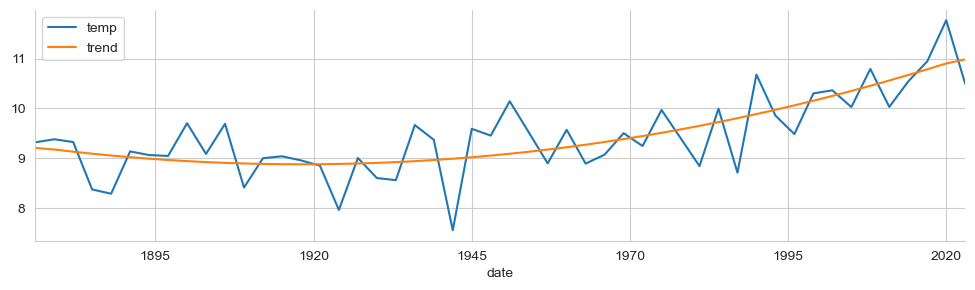

In [225]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['temp','trend']].resample('3Y').mean().plot(legend=True)
sns.despine()

In [226]:
# remove trend influence from data
train['detrended'] = train['temp'] - train['trend']

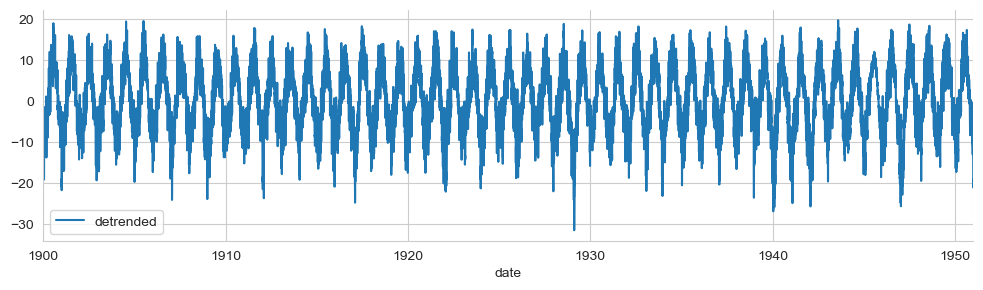

In [227]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['detrended'].loc['1900':'1950'].plot(legend=True)
sns.despine()

## Model  Sesaonality

In [228]:
# create month column
train['month'] = train.index.month

In [229]:
# feature and target for seasonality model

X_seasonality = train[['month']]
y_seasonality = train['detrended']

In [230]:
# seasonality model

seasonality_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

In [231]:
# fit model

seasonality_model.fit(X_seasonality, y_seasonality)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [232]:
train['seasonality'] = seasonality_model.predict(X_seasonality)

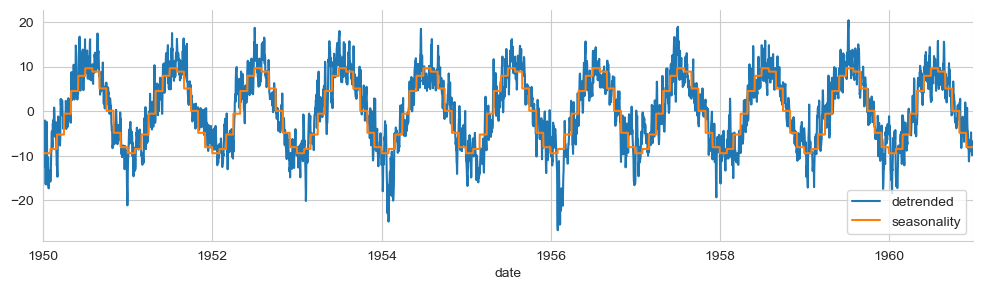

In [233]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended','seasonality']].loc['1950':'1960'].plot(legend=True)
sns.despine()

## Combine Trend & Seasonality

<AxesSubplot: xlabel='date'>

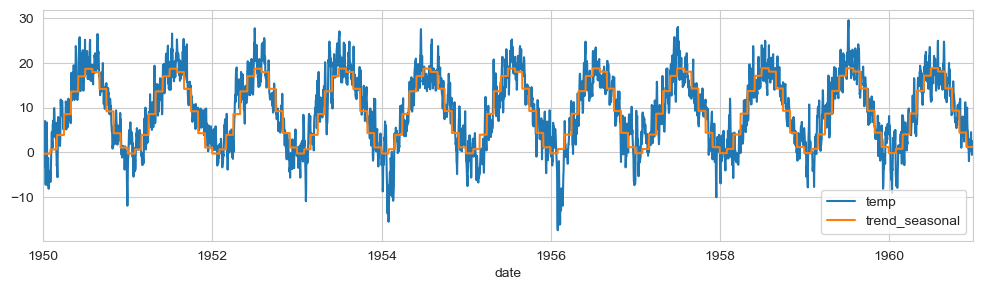

In [234]:
# combine trend and seasonality

train['trend_seasonal'] = train['trend'] + train['seasonality']

mpl.rc('figure',figsize=(12,3),dpi=100)
train[['temp','trend_seasonal']].loc['1950':'1960'].plot(legend=True)

In [235]:
# leftover time series devoid of trend and seasonality

train['remainder'] = train['temp'] - train['trend_seasonal']

In [175]:
temp_remainder = train['remainder'].reset_index()
temp_remainder.to_csv('data/temp_remainder.csv',index=False)

## Checking Remainder

### Stationarity Test

In [299]:
def p_values(series):
    """
    returns p-values for ADF and KPSS Tests on a time series
    """
    # p value from Augmented Dickey-Fuller (ADF) Test
    p_adf = adfuller(series, autolag="AIC")[1]
    
    # p value from Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test
    p_kpss = kpss(series, regression="c", nlags="auto")[1]
    
    return round(p_adf,6), round(p_kpss,6)


def test_stationarity(series):
    """
    returns likely conclusions about series stationarity
    """
    # test heteroscedasticity with qcd
    qcd = qcd_variance(series)
    
    if qcd >= 0.50:
        print(f"\n non-stationary: heteroscedastic (qcd = {qcd}) \n")
    
    # test stationarity
    else:
        p_adf, p_kpss = p_values(series)
        
        # print p-values
        print( f"\n p_adf: {p_adf}, p_kpss: {p_kpss}" )
    
        if (p_adf < 0.01) and (p_kpss >= 0.05):
            print('\n stationary or seasonal-stationary')
            
        elif (p_adf >= 0.1) and (p_kpss < 0.05):
            print('\n difference-stationary')
            
        elif (p_adf < 0.1) and (p_kpss < 0.05):
            print('\n trend-stationary')
        
        else:
            print('\n non-stationary; no robust conclusions\n')

def qcd_variance(series,window=10):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    
    # quartile coefficient of dispersion 
    qcd = (Q3-Q1)/(Q3+Q1)
    
    return round(qcd,6)

In [300]:
test_stationarity(train['remainder'])



 p_adf: 0.0, p_kpss: 0.1

 stationary or seasonal-stationary


### Time-lagged Features

In [236]:
# maximum interval to consider
p = 3
lags = [i+1 for i in range(p)]

for lag in lags:
    column_name = 'lag_' + str(lag)
    train[column_name] = train['remainder'].shift(lag)

In [237]:
train.head()

,temp,timestep,trend,detrended,month,seasonality,trend_seasonal,remainder,lag_1,lag_2,lag_3
date,,,,,,,,,,,
1876-01-01,2.2,0,9.215528,-7.015528,1,-9.418102,-0.202574,2.402574,NaN,NaN,NaN
1876-01-02,2.5,1,9.215484,-6.715484,1,-9.418102,-0.202618,2.702618,2.402574,NaN,NaN
1876-01-03,0.3,2,9.215440,-8.915440,1,-9.418102,-0.202662,0.502662,2.702618,2.402574,NaN
1876-01-04,-5.8,3,9.215395,-15.015395,1,-9.418102,-0.202707,-5.597293,0.502662,2.702618,2.402574
1876-01-05,-9.8,4,9.215351,-19.015351,1,-9.418102,-0.202751,-9.597249,-5.597293,0.502662,2.702618


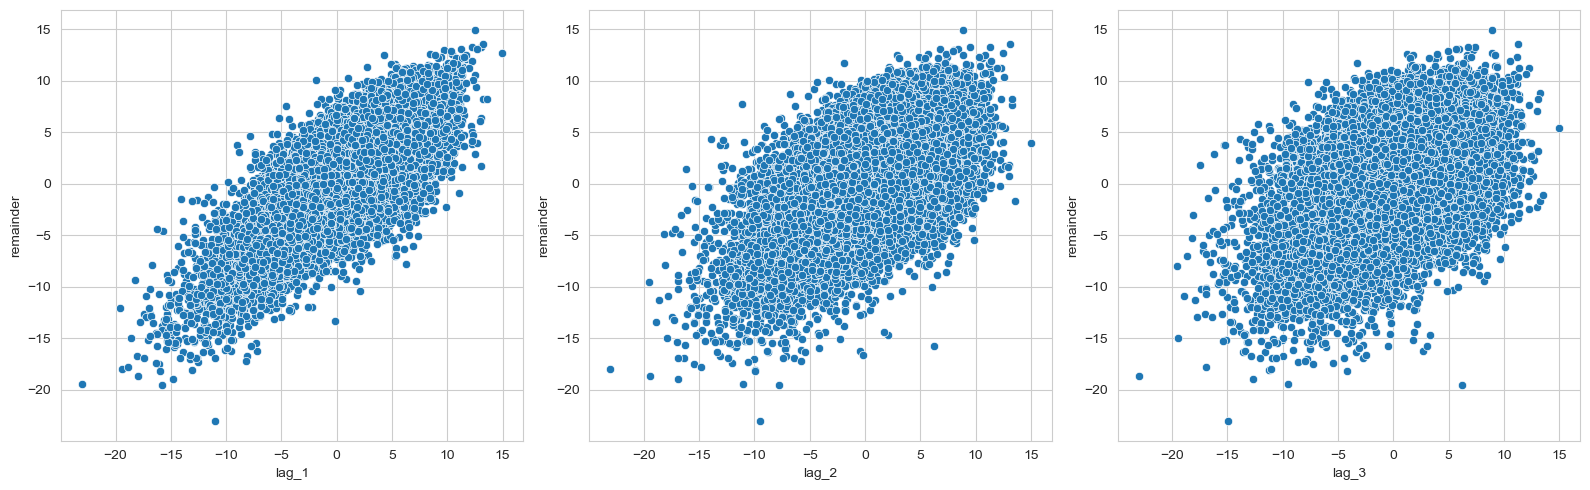

In [238]:
# scatterplot to show autocorrelation
import matplotlib.gridspec as gridspec
#sns.set() # set seaborn as default style

lag_columns = train.columns[-p:]
fig, axes = plt.subplots(1,p, figsize=(16,5),dpi=100)
gs = gridspec.GridSpec(1,p)

for i in range(p):
    sns.scatterplot(data = train, x =train[lag_columns[i]], y = train['remainder'],ax=axes[i])

    
plt.tight_layout()

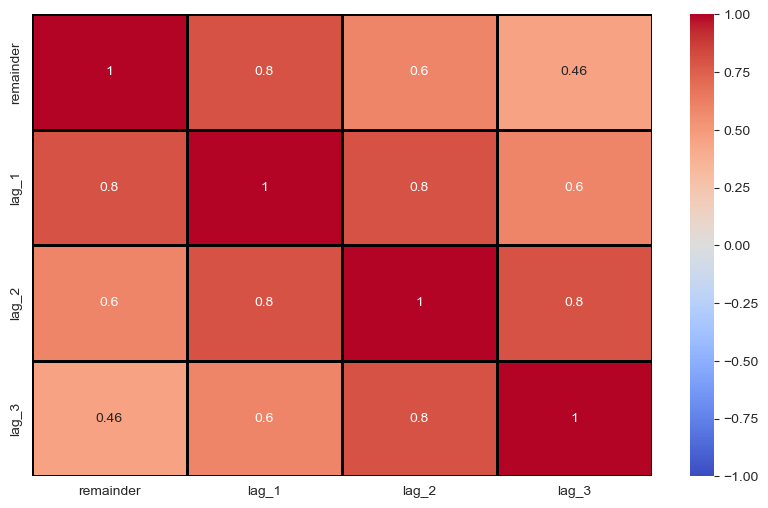

In [239]:
# heatmap to show autocorrelation
plt.rcParams['figure.figsize'] = (10,6)
sns.heatmap(round(train[['remainder', 'lag_1','lag_2', 'lag_3']].corr(),2), 
            cmap = "coolwarm",
            linecolor='black', 
            linewidth=1, 
            annot=True,
            vmin=-1, 
            vmax=1
           );

In [243]:
# Drop missing values

train.dropna(inplace=True)
train.head()

,temp,timestep,trend,detrended,month,seasonality,trend_seasonal,remainder,lag_1,lag_2,lag_3
date,,,,,,,,,,,
1876-01-04,-5.8,3,9.215395,-15.015395,1,-9.418102,-0.202707,-5.597293,0.502662,2.702618,2.402574
1876-01-05,-9.8,4,9.215351,-19.015351,1,-9.418102,-0.202751,-9.597249,-5.597293,0.502662,2.702618
1876-01-06,-7.7,5,9.215307,-16.915307,1,-9.418102,-0.202795,-7.497205,-9.597249,-5.597293,0.502662
1876-01-07,-6.6,6,9.215263,-15.815263,1,-9.418102,-0.202840,-6.397160,-7.497205,-9.597249,-5.597293
1876-01-08,-8.9,7,9.215218,-18.115218,1,-9.418102,-0.202884,-8.697116,-6.397160,-7.497205,-9.597249


In [245]:
# feature and target for autoregression model

X_remainder = train[lag_columns[:2]]
y_remainder = train['remainder']

In [246]:
# model for remainder

ar_model = LinearRegression()
ar_model.fit(X_remainder,y_remainder)

LinearRegression()

In [247]:
# prediction

train['remainder_pred_ar'] = ar_model.predict(X_remainder)

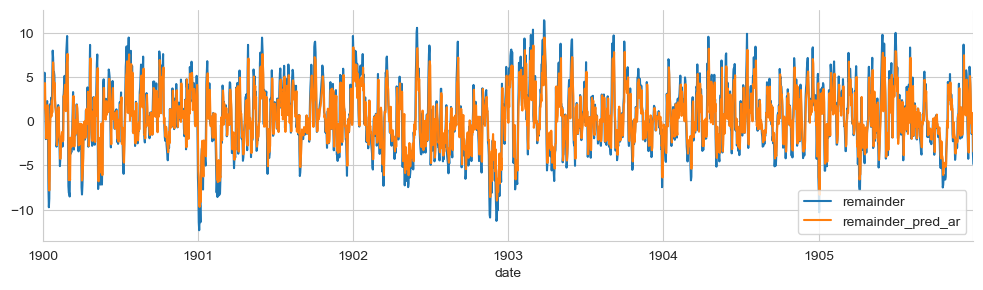

In [248]:
# Plot original remainder and prediction
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['remainder','remainder_pred_ar']].loc['1900':'1905'].plot(legend=True)
sns.despine()

### Check Remainder

In [249]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

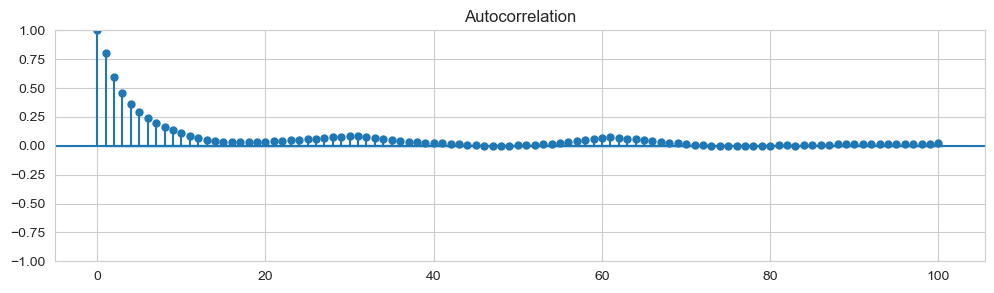

In [250]:
acf_plot = plot_acf(train.remainder, lags = 100)

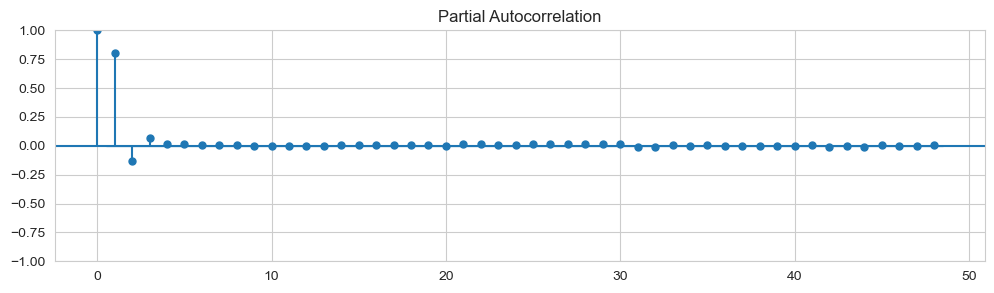

In [252]:
pact_plot = plot_pacf(train.remainder)

## Check residuals
should be around zero to show we model everyting possible

In [254]:
# residual noise

train['residuals'] = train['remainder'] - train['remainder_pred_ar']

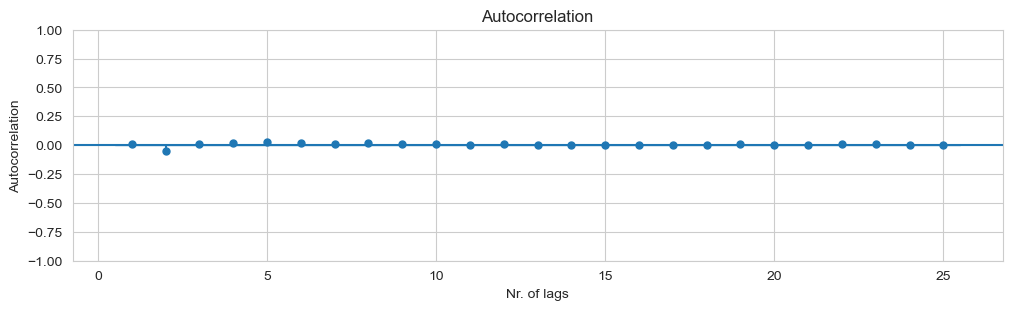

In [255]:
# plot autocorrelation function

plot_acf(train['residuals'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation')
plt.ylim(-1,1)
plt.show()

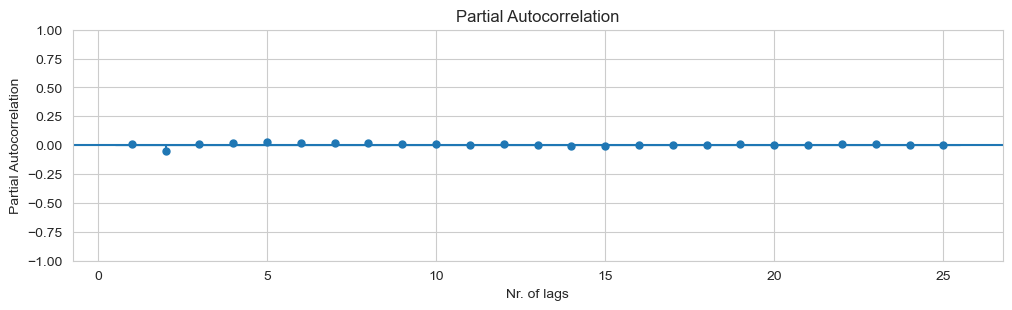

In [256]:
# plot partial autocorrelation function

plot_pacf(train['residuals'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation')
plt.ylim(-1,1)
plt.show()

In [257]:
train.head()

,temp,timestep,trend,detrended,month,seasonality,trend_seasonal,remainder,lag_1,lag_2,lag_3,remainder_pred_ar,residuals
date,,,,,,,,,,,,,
1876-01-04,-5.8,3,9.215395,-15.015395,1,-9.418102,-0.202707,-5.597293,0.502662,2.702618,2.402574,0.095024,-5.692317
1876-01-05,-9.8,4,9.215351,-19.015351,1,-9.418102,-0.202751,-9.597249,-5.597293,0.502662,2.702618,-5.163015,-4.434234
1876-01-06,-7.7,5,9.215307,-16.915307,1,-9.418102,-0.202795,-7.497205,-9.597249,-5.597293,0.502662,-7.985869,0.488664
1876-01-07,-6.6,6,9.215263,-15.815263,1,-9.418102,-0.202840,-6.397160,-7.497205,-9.597249,-5.597293,-5.537229,-0.859931
1876-01-08,-8.9,7,9.215218,-18.115218,1,-9.418102,-0.202884,-8.697116,-6.397160,-7.497205,-9.597249,-4.817601,-3.879515


In [258]:
train['total_pred'] = train['trend_seasonal'] + train['remainder_pred_ar']

In [260]:
train[['temp', 'total_pred']]

,temp,total_pred
date,,
1876-01-04,-5.8,-0.107683
1876-01-05,-9.8,-5.365766
1876-01-06,-7.7,-8.188664
1876-01-07,-6.6,-5.740069
1876-01-08,-8.9,-5.020485
...,...,...
2021-12-27,-3.9,-4.794095
2021-12-28,-0.5,-1.979506
2021-12-29,4.5,0.726626


In [270]:
r2_ts = round(r2_score(y_trend[3:], train['trend_seasonal']),6)
print(f"r2_score: {r2_ts}")

r2_score: 0.75344


In [267]:
r2_ts = round(r2_score(y_trend[3:], train['total_pred']),6)
print(f"r2_score: {r2_ts}")

r2_score: 0.913854


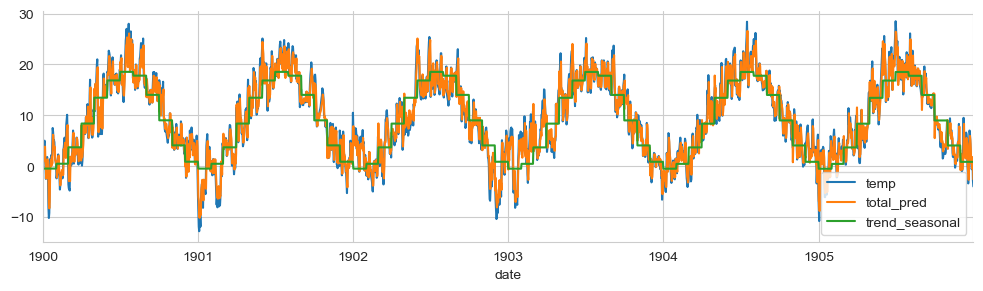

In [271]:
# Plot original prediction for trend&seasonaity and total prediction
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['temp', 'total_pred', 'trend_seasonal']].loc['1900':'1905'].plot(legend=True)
sns.despine()

# Forcast for test set

In [272]:
test = pd.read_csv('data/test.csv',index_col=0,parse_dates=True)

In [274]:
# add timestep
test['timestep'] = list(range(train.shape[0], train.shape[0] + test.shape[0]))

In [276]:
# add month
test['month'] = test.index.month

In [279]:
X_test_trend = test[['timestep']]
y_test = test['temp']

In [280]:
test['trend'] = trend_model.predict(X_test_trend)
test['seasonality'] = seasonality_model.predict(test[['month']])

In [281]:
test.head()

,temp,timestep,month,trend,seasonality
date,,,,,
2022-01-01,12.0,53323,1,11.002006,-9.418102
2022-01-02,9.9,53324,1,11.002117,-9.418102
2022-01-03,8.9,53325,1,11.002229,-9.418102
2022-01-04,6.4,53326,1,11.002340,-9.418102
2022-01-05,3.8,53327,1,11.002451,-9.418102


In [282]:
test['trend_seasonal'] = test['trend'] + test['seasonality']
test.head()

,temp,timestep,month,trend,seasonality,trend_seasonal
date,,,,,,
2022-01-01,12.0,53323,1,11.002006,-9.418102,1.583904
2022-01-02,9.9,53324,1,11.002117,-9.418102,1.584015
2022-01-03,8.9,53325,1,11.002229,-9.418102,1.584126
2022-01-04,6.4,53326,1,11.002340,-9.418102,1.584238
2022-01-05,3.8,53327,1,11.002451,-9.418102,1.584349


In [284]:
def forecast_remainder(*lags):
    """
    spits out forecasted remainded for test data,
    given intitial lagged varibales
    """
    
    predicted_remainders = []
    lag_values = list(lags)
    
    for i in range(test.shape[0]):
        
        # row of lagged features
        X = [lag_values] # list of list
        
        # predict remainder
        remainder = ar_model.predict(X)[0]
        
        # append remainded
        predicted_remainders.append(remainder)
        
        # lag values for next step
        lag_values = [remainder] + lag_values[:-1]
        
    return predicted_remainders

In [285]:
lag1 = train.iloc[-1]['remainder'] 
lag2 = train.iloc[-1]['lag_1']

In [286]:
test['total_pred'] = test['trend_seasonal'] + forecast_remainder(lag1,lag2)

In [288]:
test[['temp', 'total_pred']]

,temp,total_pred
date,,
2022-01-01,12.0,9.887979
2022-01-02,9.9,7.794072
2022-01-03,8.9,6.123321
2022-01-04,6.4,4.883334
2022-01-05,3.8,3.978718
...,...,...
2022-12-27,4.2,2.981680
2022-12-28,6.3,2.981793
2022-12-29,10.0,2.981905


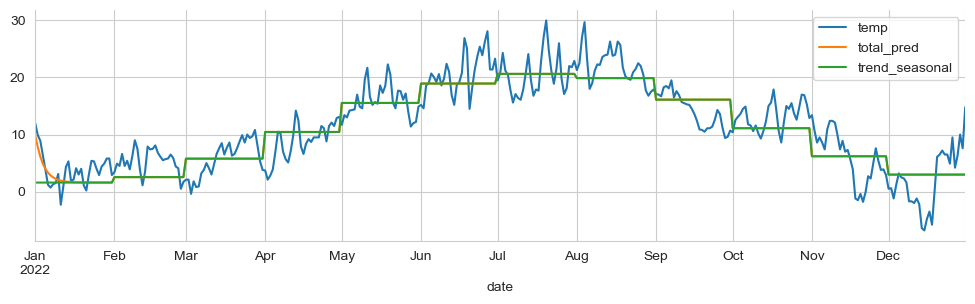

In [291]:
# Plot test origin temp, trend+seasonality & total prediction
mpl.rc('figure',figsize=(12,3),dpi=100)

test[['temp', 'total_pred', 'trend_seasonal']].plot(legend=True)
sns.despine()

In [292]:
r2_ts = round(r2_score(y_test, test['trend_seasonal']),6)
print(f"r2_score: {r2_ts}")

r2_score: 0.763688


In [293]:
r2_ts = round(r2_score(y_test, test['total_pred']),6)
print(f"r2_score: {r2_ts}")

r2_score: 0.774591
